In [1]:
import os
import warnings
from io import BytesIO
from pathlib import Path

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import ListedColormap
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

from feature_utils import normalize_histogram

warnings.filterwarnings("ignore")

2023-12-10 15:36:28.338627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 15:36:28.338680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 15:36:28.339527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 15:36:28.345157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_path = Path("./sign_data/")
if not dataset_path.joinpath("data").exists():
    dataset_path = Path("./")

In [3]:
# Read the parquet file, this takes a while. Leave it here
features_file = dataset_path.joinpath("data/train_features.parquet")
test_file = dataset_path.joinpath("data/test_features.parquet")
meta_file = dataset_path.joinpath("data/meta_full.parquet")

dft = pl.read_parquet(features_file, memory_map=True)
dfe = pl.read_parquet(test_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)

dft = dft.join(dfm, on="ClassId")
dfe = dfe.join(dfm, on="ClassId")

del dfm

In [4]:
samples_per_class = 200
random_seed = 42
features = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, seed=random_seed)
        for x in dft.partition_by("ClassId")
    ]
)

In [5]:
dfe.head(1)
# Test distribution:
# features.groupby("ClassId").agg(pl.count())

id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,16,64,64,[binary data],4096,[binary data],"[63, 58, … 113]","[0, 0, … 0]","[0, 0, … 0]",[binary data],"[195, 142, … 0]","[0.119428, 0.135571, … 0.005196]",[binary data],"[0.097359, 0.076541, … 0.101359]","[0.867967, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""/work/06333/ed…",1,0,"""3.3""","""Over 3.5 Tons …",[binary data],100,100,10000,64,64,[binary data],4096


In [6]:
columns = [
    "ClassId",
    "Hue_Hist",
    "Saturation_Hist",
    "HOG_Features",
    "Template_Pattern",
    "RESNET101",
    "VGG16",
    "LBP_Image",
]
features = features[columns]
features.head(1)

ClassId,Hue_Hist,Saturation_Hist,HOG_Features,Template_Pattern,RESNET101,VGG16,LBP_Image
i64,list[i64],list[i64],list[f32],list[f32],list[f64],list[f64],binary
20,"[972, 151, … 16]","[247, 0, … 0]","[0.25923, 0.184951, … 0.0]","[0.245245, 0.24306, … 0.12408]","[0.812232, 0.0, … 0.0]","[0.0, 0.0, … 0.0]",[binary data]


In [7]:
test_features = dfe[columns]
test_features.head(1)

ClassId,Hue_Hist,Saturation_Hist,HOG_Features,Template_Pattern,RESNET101,VGG16,LBP_Image
i64,list[i64],list[i64],list[f32],list[f32],list[f64],list[f64],binary
16,"[63, 58, … 113]","[0, 0, … 0]","[0.119428, 0.135571, … 0.005196]","[0.097359, 0.076541, … 0.101359]","[0.867967, 0.0, … 0.0]","[0.0, 0.0, … 0.0]",[binary data]


In [8]:
del dft
del dfe

### Logistic Regression Model

In [9]:
def build_model(num_features, learning_rate=0.001):
    """Build a TF linear regression model using Keras.

    Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # Setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.Sequential()

    model.add(
        tf.keras.layers.Dense(
            units=43,  # output dim
            input_shape=[num_features],  # input dim
            use_bias=True,  # use a bias (intercept) param
            kernel_initializer=tf.ones_initializer,  # initialize params to 1
            bias_initializer=tf.ones_initializer,  # initialize bias to 1
            activation="softmax",
        )
    )

    # We'll use SGD
    # We will specify the batch size to use for training later.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, we compile the model. This finalizes the graph for training.
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    return model

In [10]:
def plot_loss(history, title):
    """Plot the loss after each training epoch."""
    # Convert the history object into a DataFrame.
    history = pd.DataFrame(history.history)
    history = history[np.isfinite(history).all(1)]

    plt.suptitle("Models", fontsize=16, color="black", fontweight="bold")

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(len(history)), history["loss"], marker=".", color="black")
    plt.plot(range(len(history)), history["val_loss"], marker=".", color="red")
    plt.legend(["train loss", "validation loss"])
    plt.title(title)
    plt.show()

    # Show the final train loss value and the learned model weights.
    print("Final train loss:", list(history["loss"])[-1])

In [11]:
# Create a confusion matrix as a 2D array.
def plot_confusion_matrix(title, y_test, y_prediction):
    label_names = [f"Class {i}" for i in range(43)]

    confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(12, 10))

    color_map1 = ["lightgrey", "#ffff99", "orange", "#7fc97f"]
    color_map = ListedColormap(color_map1)

    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=color_map,
        linewidths=0.5,
        square=True,
        cbar_kws={"label": "Count"},
        xticklabels=label_names,
        yticklabels=label_names,
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(title + " Confusion Matrix", fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=80, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Adjust layout to prevent cutoff of labels
    plt.tight_layout()

    # Add axis labels.
    # ax.set(xlabel="Predicted Label", ylabel="True Label")
    plt.show()
    return

<HR>

### HOG Features

In [12]:
# Derive HOG dataset


features_hog = features["HOG_Features"].to_numpy()
features_hog = np.stack(features_hog)

# split the data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(
    features_hog, features["ClassId"].to_numpy(), test_size=0.2, random_state=42
)

# X_train = features['HOG_Features'].to_numpy()
# X_train = np.stack(X_train)
# y_train = features['ClassId'].to_numpy()

# X_test = test_features['HOG_Features'].to_numpy()
# X_test = np.stack(X_test)
# y_test = test_features['ClassId'].to_numpy()

In [13]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (6880, 2916)
y_train.shape: (6880,)
X_test.shape: (1720, 2916)
y_test.shape: (1720,)


In [14]:
num_features = X_train.shape[1]
learningRate = 0.1
model = build_model(num_features, learningRate)
# print(model.summary())

history = model.fit(
    x=X_train, y=y_train, epochs=50, verbose=0, validation_split=0.1, batch_size=100
)

2023-12-10 15:38:05.207975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 15:38:05.217627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 15:38:05.217873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 15:38:05.219490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 15:38:05.219742: I external/local_xla/xla/stream_executor

In [15]:
# Make predictions on test data using HOG Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=200)
print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=200)

test_rmse = np.sqrt(test_loss)
print("Test rmse:", test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row += 1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy * 100)

Evaluate on test data
9/9 [==============================] - 0s 4ms/step - loss: 0.2387 - accuracy: 0.9686
test loss, test acc: [0.2387246936559677, 0.9686046242713928]
Test rmse: [0.48859461 0.98417713]
54/54 [==============================] - 0s 2ms/step

Accuracy on Test Set: 96.86046511627907


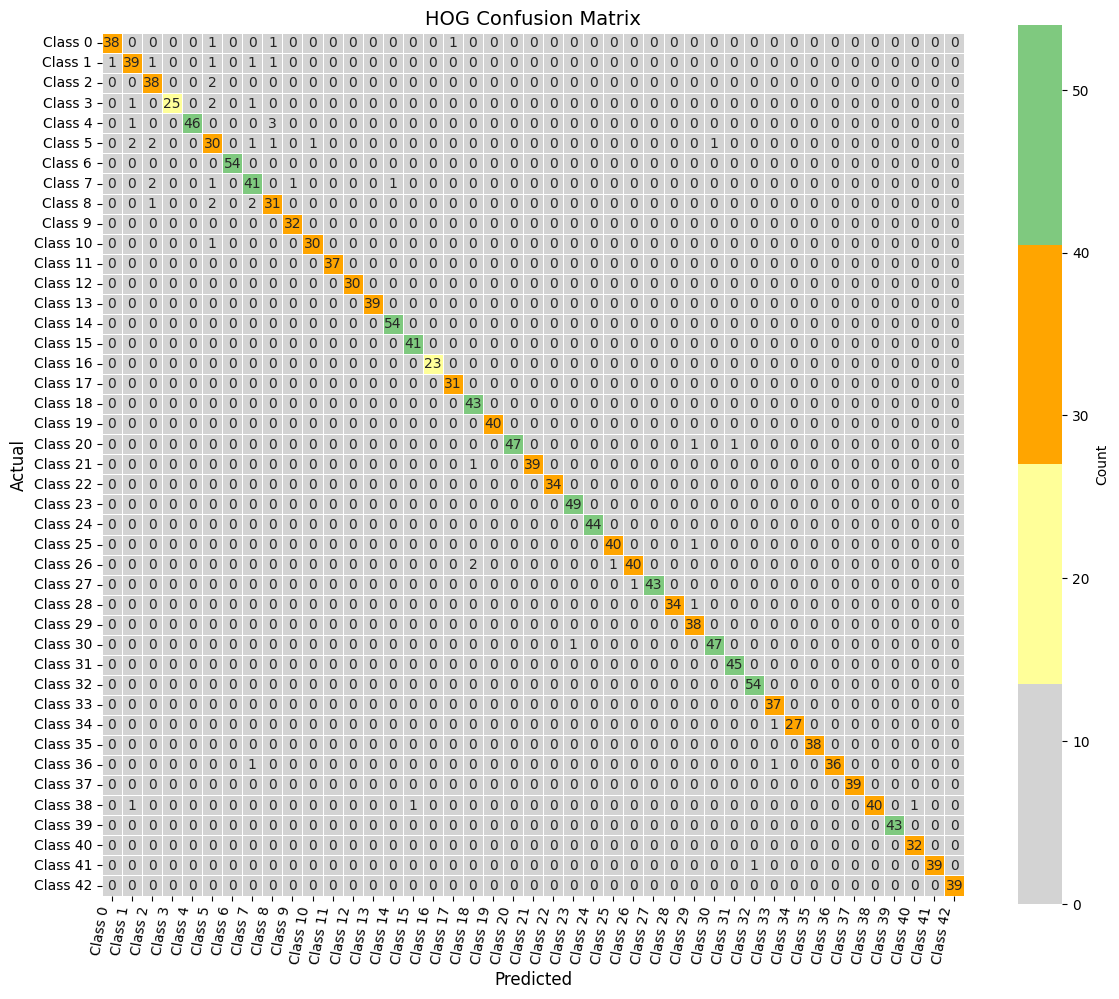

In [16]:
# Create a confusion matrix as a 2D array.

title = "HOG"
label_names = [f"Class {i}" for i in range(43)]

confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(12, 10))

# Use a heatmap plot to display it.
# ax = sns.heatmap(
#     confusion_matrix,
#     annot=True,
#     fmt=".3g",
#     cmap=ListedColormap(sns.color_palette("viridis")),
#     xticklabels=label_names,
#     yticklabels=label_names,
#     cbar=False,
# )
color_map1 = ["lightgrey", "#ffff99", "orange", "#7fc97f"]
color_map = ListedColormap(color_map1)
# color_map = ListedColormap(sns.color_palette("viridis"))

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=color_map,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=label_names,
    yticklabels=label_names,
    annot_kws={"size": 10},
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title(title + " Confusion Matrix", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=80, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Add axis labels.
# ax.set(xlabel="Predicted Label", ylabel="True Label")
plt.show()

<HR>

### Template Match Features

In [17]:
# Derive Template dataset

features_tem = features["Template_Pattern"].to_numpy()
features_tem = np.stack(features_tem)

# split the data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(
    features_tem, features["ClassId"].to_numpy(), test_size=0.2, random_state=42
)

# X_train = features['Template_Pattern'].to_numpy()
# X_train = np.stack(X_train)
# y_train = features['ClassId'].to_numpy()

# X_test = test_features['Template_Pattern'].to_numpy()
# X_test = np.stack(X_test)
# y_test = test_features['ClassId'].to_numpy()

In [18]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (6880, 3483)
y_train.shape: (6880,)
X_test.shape: (1720, 3483)
y_test.shape: (1720,)


In [19]:
num_features = X_train.shape[1]
learningRate = 0.01
model = build_model(num_features, learningRate)
# print(model.summary())

history = model.fit(
    x=X_train, y=y_train, epochs=50, verbose=0, validation_split=0.1, batch_size=100
)

In [20]:
# Make predictions on test data using Template Matching Features
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=200)

test_rmse = np.sqrt(test_loss)
print("Test rmse:", test_rmse)


# Predict
y_pred = model.predict(X_test)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row += 1

accuracy = accuracy_score(y_test, y_prediction)
print("\nAccuracy on Test Set:", accuracy * 100)

Evaluate on test data
54/54 [==============================] - 0s 3ms/step - loss: 2.1922 - accuracy: 0.5610
test loss, test acc: [2.1921629905700684, 0.5610465407371521]
Test rmse: [1.48059532 0.7490304 ]
54/54 [==============================] - 0s 2ms/step

Accuracy on Test Set: 56.104651162790695


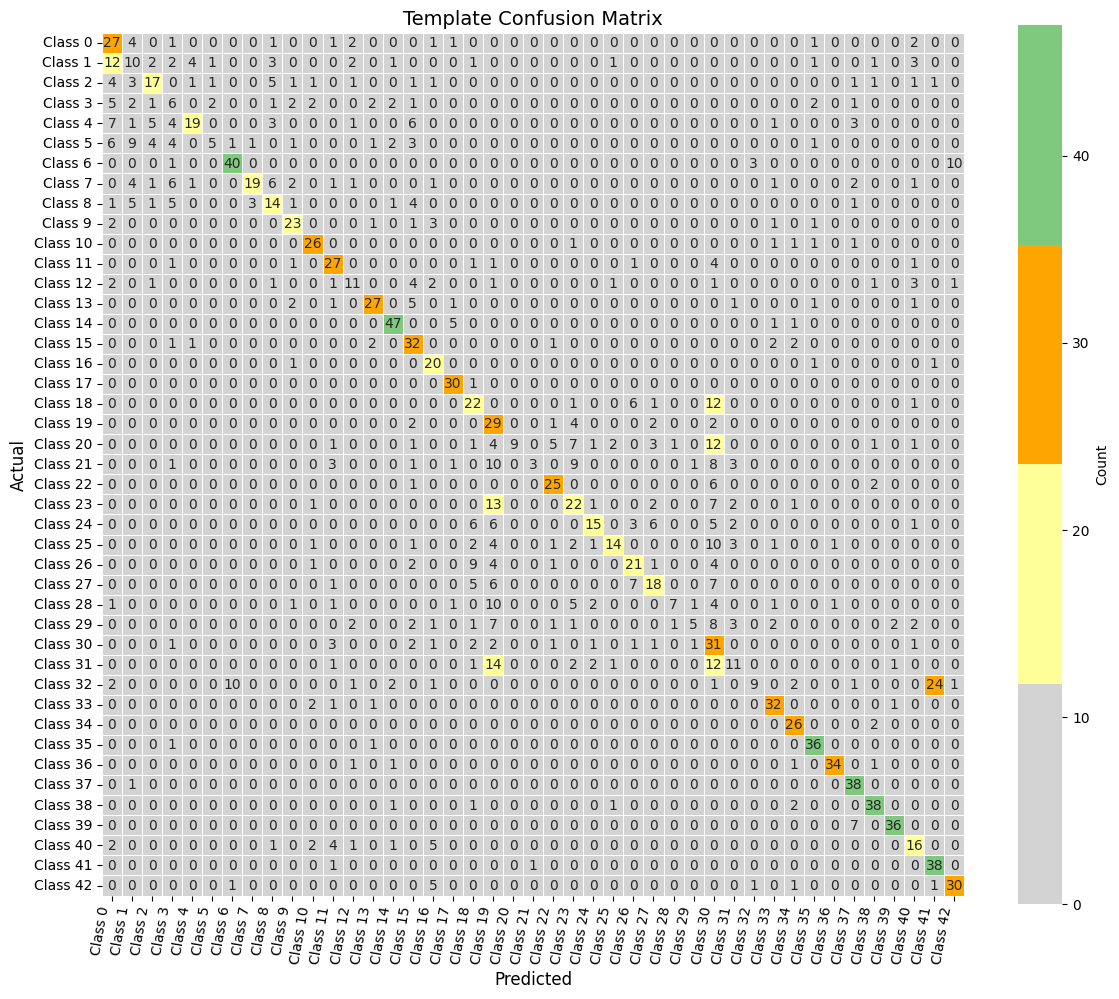

In [21]:
# Create a confusion matrix as a 2D array.

title = "Template"
label_names = [f"Class {i}" for i in range(43)]

confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(12, 10))

# Use a heatmap plot to display it.
# ax = sns.heatmap(
#     confusion_matrix,
#     annot=True,
#     fmt=".3g",
#     cmap=ListedColormap(sns.color_palette("viridis")),
#     xticklabels=label_names,
#     yticklabels=label_names,
#     cbar=False,
# )
color_map1 = ["lightgrey", "#ffff99", "orange", "#7fc97f"]
color_map = ListedColormap(color_map1)
# color_map = ListedColormap(sns.color_palette("viridis"))

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=color_map,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=label_names,
    yticklabels=label_names,
    annot_kws={"size": 10},
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title(title + " Confusion Matrix", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=80, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent cutoff of labels
plt.tight_layout()

# Add axis labels.
# ax.set(xlabel="Predicted Label", ylabel="True Label")
plt.show()

<HR>

### RESNET & VGG16 Features

Evaluate on test data
54/54 [==============================] - 0s 3ms/step - loss: 2.1922 - accuracy: 0.5610
test loss, test acc: [2.192162275314331, 0.5610465407371521]
Test rmse: [1.48059524 0.7490304 ]
54/54 [==============================] - 0s 1ms/step

Accuracy on Test Set: 56.104651162790695


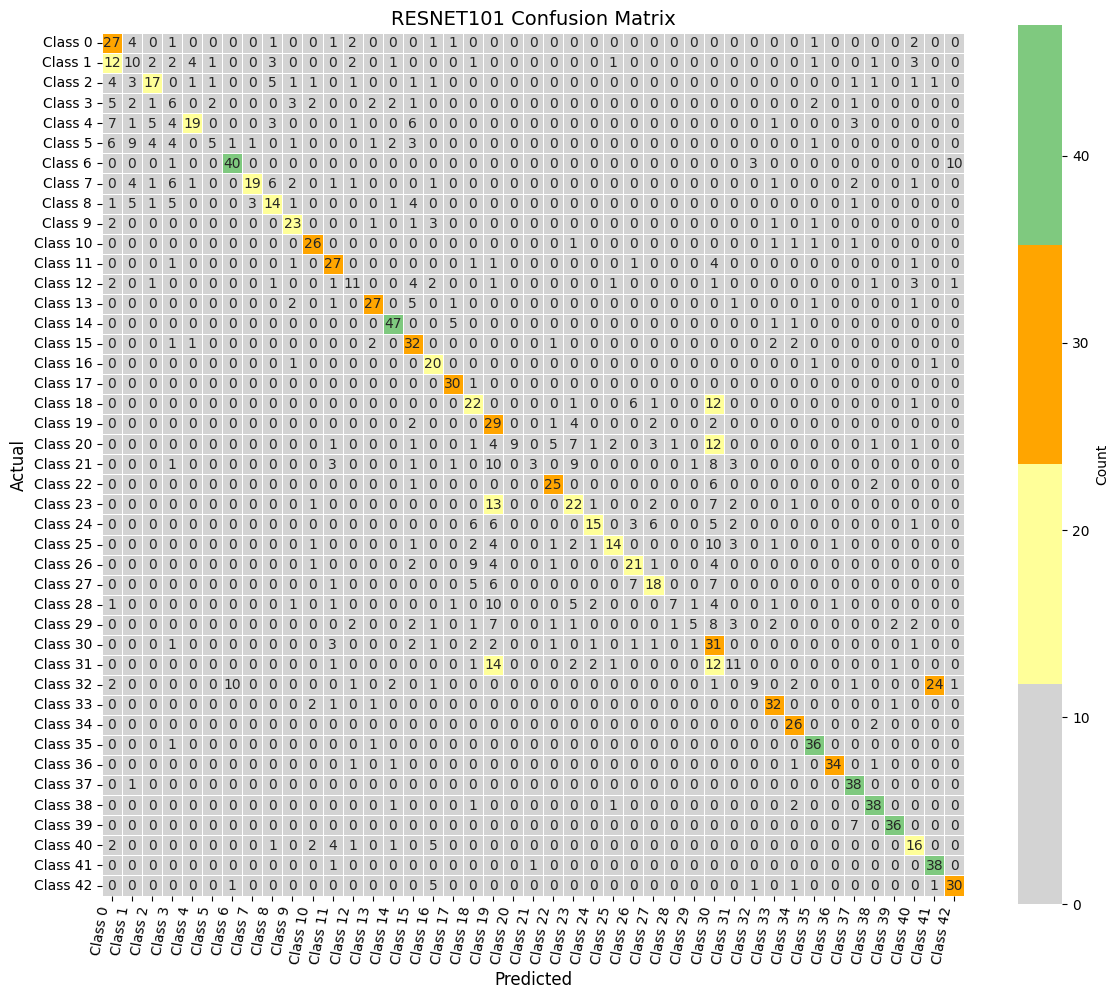

Evaluate on test data
54/54 [==============================] - 0s 2ms/step - loss: 2.1922 - accuracy: 0.5610
test loss, test acc: [2.192162275314331, 0.5610465407371521]
Test rmse: [1.48059524 0.7490304 ]
54/54 [==============================] - 0s 2ms/step

Accuracy on Test Set: 56.104651162790695


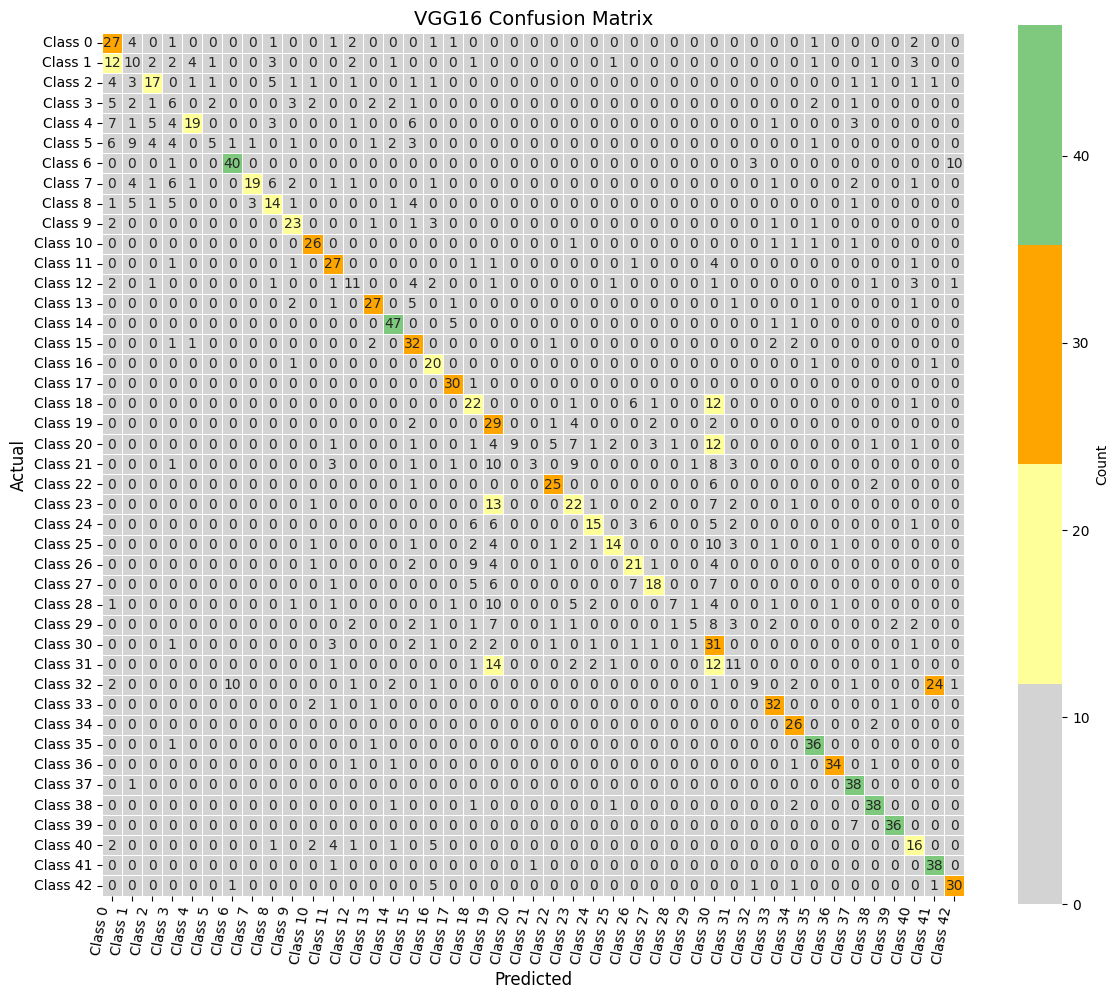

In [22]:
cols = ["RESNET101", "VGG16"]
models = []

for f in cols:
    # Derive Template dataset

    features_x = features[f].to_numpy()
    features_x = np.stack(features_tem)

    # split the data into train, validation and test
    X_train, X_test, y_train, y_test = train_test_split(
        features_x, features["ClassId"].to_numpy(), test_size=0.2, random_state=42
    )

    # X_train = features['Template_Pattern'].to_numpy()
    # X_train = np.stack(X_train)
    # y_train = features['ClassId'].to_numpy()

    # X_test = test_features['Template_Pattern'].to_numpy()
    # X_test = np.stack(X_test)
    # y_test = test_features['ClassId'].to_numpy()

    num_features = X_train.shape[1]
    learningRate = 0.01
    model = build_model(num_features, learningRate)

    history = model.fit(
        x=X_train, y=y_train, epochs=50, verbose=0, validation_split=0.1, batch_size=100
    )

    models.append(history)

    # Make predictions on test data using Template Matching Features
    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=32)
    print("test loss, test acc:", results)

    test_loss = model.evaluate(x=X_test, y=y_test, verbose=0, batch_size=32)

    test_rmse = np.sqrt(test_loss)
    print("Test rmse:", test_rmse)

    # Predict
    y_pred = model.predict(X_test)

    y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
    row = 0
    for p in y_pred:
        clase = np.argmax(p)
        y_prediction[row] = clase
        row += 1

    accuracy = accuracy_score(y_test, y_prediction)
    print("\nAccuracy on Test Set:", accuracy * 100)

    plot_confusion_matrix(f, y_test, y_prediction)

<HR>

In [23]:
# # Run base model per feature (excluding pattern matching)
# # Using Train sample (200 images per class)
# NUM_BATCH = 32
# EPSILON = 0.0001
# EPOCHS = 50
# SPLIT = 0.10

# params = []
# for col in columns:
#     learningRate = EPSILON
#     epochs = EPOCHS

#     if col == 'HOG_Features':
#         learningRate = 0.01
#         epochs = 100
#     elif col == 'LBP_Hist':
#         learningRate = 0.01
#         epochs = 10
#     elif col == 'Template_Pattern':
#         learningRate = 0.001
#         epochs = 60
#     elif col == 'RESNET101':
#         learningRate = 0.001
#         epochs = 90

#     params.append([col, learningRate, epochs])


# models = []

# for col in columns[1:]:
#     train_features, labels = features[col], features['ClassId']
#     split = int(train_features.shape[0] * SPLIT)
#     val_features, v_labels = train_features[-split:], labels[-split:]
#     train_features, t_labels = train_features[:-split], labels[:-split]

#     tdataset = tf.data.Dataset.from_tensors(((np.vstack(train_features)), t_labels))
#     vdataset = tf.data.Dataset.from_tensors(((np.vstack(val_features)), v_labels))

#     tdataset.batch(NUM_BATCH)

#     parmts = [e for e in params if e[0]==col][0]
#     learningRate = parmts[1]
#     epochs = parmts[2]

#     print(f'Model for {col}')
#     print('='*100)
#     num_features = train_features[0].len()
#     model = build_model(num_features, learningRate)
#     print(model.summary())

#     history = model.fit(tdataset, epochs=epochs, verbose=1, validation_data=vdataset)
#     models.append((model, history, col, learningRate))
#     print('='*100, '\n\n')

In [24]:
plt.figure(figsize=(10, 14))
plt.suptitle("Models", fontsize=16, color="black", fontweight="bold")

for i, m in enumerate(models):
    hist = pd.DataFrame(m[1].history)
    hist = hist[np.isfinite(hist).all(1)]

    ax = plt.subplot(5, 2, i + 1)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(len(hist)), hist["loss"], marker=".", color="black")
    plt.plot(range(len(hist)), hist["val_loss"], marker=".", color="red")
    plt.legend(["train loss", "validation loss"])
    plt.title(m[2])

    loss = "Final train loss: {lo:e}"
    loss = loss.format(lo=list(hist["loss"])[-1])

    lrate = "Learning rate: {ep:.4f}"
    lrate = lrate.format(ep=m[3])

    plt.text(0.1, 0.55, loss, ha="left", va="top", transform=ax.transAxes, color="blue")
    plt.text(
        0.1, 0.45, lrate, ha="left", va="top", transform=ax.transAxes, color="black"
    )


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

TypeError: 'History' object is not subscriptable

<Figure size 1000x1400 with 0 Axes>